In [47]:
%load_ext autoreload
%autoreload 1
%aimport ECGDataset
%aimport Models
%aimport train_test_validat
%aimport self_attention
%aimport ECGplot
%aimport Net
%aimport ECGHandle

import ECGDataset 
import Models 
import Net
from train_test_validat import *
from self_attention import *
import matplotlib.pyplot as plt
import ecg_plot
import cam
import ECGplot
import ECGHandle
import torch
import torch.utils.data as Data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import random
import pandas as pd
from tqdm import tqdm

import time
import math
import os
import gc
from torch.utils.tensorboard import SummaryWriter


def seed_torch(seed=2023):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	torch.backends.cudnn.benchmark = False 
	torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.enabled = False
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
EcgChannles_num = 12
EcgLength_num = 5000
DEVICE = "cpu"
seed_torch(2023)
plt.rcParams['font.sans-serif'] = ['SimHei'] #或者把"SimHei"换为"KaiTi"

In [49]:
supplement_diagnose = pd.read_csv('./补充诊断.csv',encoding='utf-8-sig')
supplement_diagnose['ID'] = supplement_diagnose['ID'].astype(str)
# 使用groupby方法按照ID分组，然后使用agg方法将data列拼接在一起
supplement_diagnose = supplement_diagnose.groupby('ID')['住院所有诊断'].agg(lambda x: ','.join(x.astype(str))).reset_index()
# 使用str.contains方法筛选data列中包含‘高血压’的行
filtered_df = supplement_diagnose[supplement_diagnose['住院所有诊断'].str.contains('高血压')]
# 将筛选后的ID列转换为list
id_list = filtered_df['ID'].astype(str).tolist()

In [50]:
def filter_diagnose(df_input,remove_diagnose = ''): 
    df_filter = df_input.copy()
    if(remove_diagnose):
        fitler_ID_list = df_filter[(df_filter['concat'].str.contains(remove_diagnose) == True)]['ID'].tolist()
        fitler_index = df_filter[[True if i in fitler_ID_list else False for i in df_filter['ID']]].index #选取出所有含有该ID的样本
        df_remove = df_filter.loc[(fitler_index)]
        no_fitler_index = df_filter[[False if i in fitler_ID_list else True for i in df_filter['ID']]].index #选取出所有不含有该ID的样本
        df_filter = df_filter.loc[(no_fitler_index)]
        
        print('\n')
        print("{:^10} {:^10} {:^20}".format('  ','orginal','remove diagnose' + remove_diagnose))
        print("{:^10} {:^10} {:^20}".format('nums',len(df_input),len(df_filter)))
        print("{:^10} {:^10} {:^20}".format('  ','HTN','NHTN'))
        print("{:^10} {:^10} {:^20}".format('nums',len(df_filter[(df_filter['label']==1)]),len(df_filter[(df_filter['label']==0)])))
        print("{:^10} {:^10} {:^20}".format('  ','remove HTN','remove NHTN'))
        print("{:^10} {:^10} {:^20}".format('nums',len(df_remove[(df_remove['label']==1)]),len(df_remove[(df_remove['label']==0)])))
        return df_filter
def correct_label(df_input,reset_list = ['848023',
                                        '848316',
                                        '578148',
                                        '736912',
                                        '847065',
                                        '849400',
                                        '839738',
                                        '309738',
                                        '496939',
                                        '847724',
                                        '847377',
                                        '848996',
                                        '850179',
                                        '844904',
                                        '848473',]): #更改错误的label
    print('\n')
    df_filter = df_input.copy()
    df_filter = df_filter.sort_values(by=['label'], ascending=[False]) #按照诊断排序，HTN在前
    #####################################################test
    #将确认为HTN的错误样本的标签重置###reset lable 
    reset_index = df_filter[[True if i in reset_list else False for i in df_filter['ID']]].index
    df_filter.loc[reset_index,'label'] = 1
    print("{:^20} {:^5}".format("reset num:",len(reset_index)))
    #####################################################test 把住院号相同但诊断标签不一致的全部改为HTN
    df0 = df_filter[df_filter['label']==0] #所有非高血压
    df1 = df_filter[df_filter['label']==1] #所有高血压
    duplicated_index = df0[[True if i in df1['ID'].tolist() else False for i in df0['ID']]].index
    df_filter.loc[duplicated_index,'label'] = 1   
    print("{:^20} {:^5}".format("ERR labels num:",len(duplicated_index))) 
    #####################################################test
    print("{:^10} {:^10} {:^20}".format('  ','orginal','correct label'))
    print("{:^10} {:^10} {:^20}".format('nums',len(df_input),len(df_filter)))
    print("{:^10} {:^10} {:^20}".format('  ','HTN','NHTN'))
    print("{:^10} {:^10} {:^20}".format('nums',len(df_filter[(df_filter['label']==1)]),len(df_filter[(df_filter['label']==0)])))
    return df_filter

In [52]:
data_root = '/workspace/data/Preprocess_HTN/datas_/'
ALL_data = pd.read_csv(data_root+'/All_data_handled_ID_range_age_IDimputate.csv',low_memory=False)
# ALL_data = ECGHandle.correct_age(ALL_data)
ALL_data = ALL_data.rename(columns={'住院号':'ID','年龄':'age','性别':'gender','姓名':'name'}) 
ALL_data = ALL_data[(ALL_data['申请部门'].str.contains('重症') == False)]
ALL_data = ALL_data[(~ALL_data['ID'].isnull())] #ID NULL
ALL_data = ALL_data[(~ALL_data['gender'].isnull())] #ID NULL
ALL_data = ALL_data[(ALL_data['Q']<1)&(~ALL_data['Q'].isnull())]#q_sum<qc_threshold
ALL_data = ALL_data[((ALL_data['age'].apply(int))>17) ]# 选年龄

ALL_data['诊断'] = ALL_data['诊断'].fillna(value='')
ALL_data['临床诊断'] = ALL_data['临床诊断'].fillna(value='')

#添加补充诊断
ALL_data = pd.merge(ALL_data,supplement_diagnose,how='inner',on='ID').reset_index()
# 使用groupby和agg函数将具有相同'ID'的行的data、data1和data2列拼接在一起
# 使用lambda函数和join方法将每个分组的值用逗号分隔
# 保留所有的行和列，使用merge方法将拼接后的结果与原始数据框合并
# 重置索引并重命名新的列为'concat'
df_concat = ALL_data.groupby('ID')[[ '诊断','住院所有诊断', '临床诊断',]].agg(lambda x: ','.join(x)).reset_index()
df_concat['concat'] = df_concat.apply(lambda x: ','.join([x['诊断'], x['住院所有诊断'], x['临床诊断']]), axis=1)
df_concat.drop(['诊断','住院所有诊断', '临床诊断'], axis=1, inplace=True) 
df_merge = ALL_data.merge(df_concat, on='ID', how='left') 

df_merge.loc[(df_merge['concat'].str.contains('高血压')==True),'label']= 1 # concat diagnose含有高血压的label为1
df_merge.loc[~(df_merge['label']==1),'label']= 0 #diagnose不含有高血压的label为0

# Replace '男' with 1 and '女' with 2 in the 'gender' column of df
df_merge['gender'].replace({'男': 1, '女': 2}, inplace=True)
df_merge['label'] = pd.to_numeric(df_merge['label'],errors='coerce', downcast='integer') #把label（diagnose）改成数值型
df_merge['age'] = pd.to_numeric(df_merge['age'],errors='coerce', downcast='integer') #把label（diagnose）改成数值型
df_merge['gender'] = pd.to_numeric(df_merge['gender'],errors='coerce', downcast='integer') #把label（diagnose）改成数值型

df_merge.drop_duplicates(subset=['ID'],keep='last')#删除重复的

print("{:^10} {:^10} {:^20}".format('  ','HTN','NHTN'))
print("{:^10} {:^10} {:^20}".format('nums',len(df_merge[(df_merge['label']==1)]),len(df_merge[(df_merge['label']==0)])))

df_merge = ECGHandle.filter_departmentORlabel(df_merge,'外')

df_merge = filter_diagnose(df_merge,'起搏')
df_merge = filter_diagnose(df_merge,'除颤')
df_merge = filter_diagnose(df_merge,'电解质')
df_merge = filter_diagnose(df_merge,'钙血')
df_merge = filter_diagnose(df_merge,'钾血')
df_merge = filter_diagnose(df_merge,'镁血')


              HTN             NHTN        
   nums      14142           33467        


            orginal   filtered department 
   nums      47609           25468        
              HTN             NHTN        
   nums      14142           11326        


            orginal    remove diagnose起搏  
   nums      25468           25063        
              HTN             NHTN        
   nums      13765           11298        
           remove HTN     remove NHTN     
   nums       377              28         


            orginal    remove diagnose除颤  
   nums      25063           25063        
              HTN             NHTN        
   nums      13765           11298        
           remove HTN     remove NHTN     
   nums        0               0          


            orginal    remove diagnose电解质 
   nums      25063           24099        
              HTN             NHTN        
   nums      12943           11156        
           remove HTN     remove NHTN     
   

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


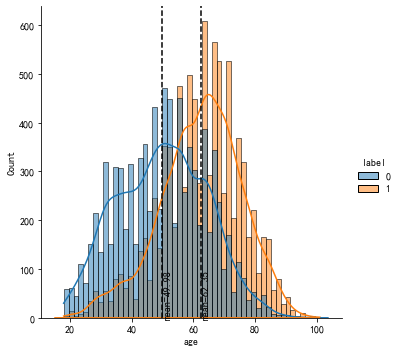

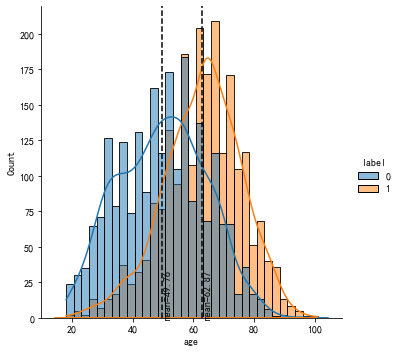

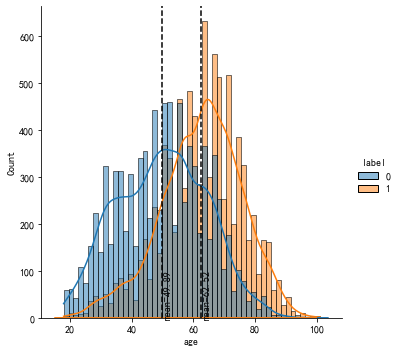

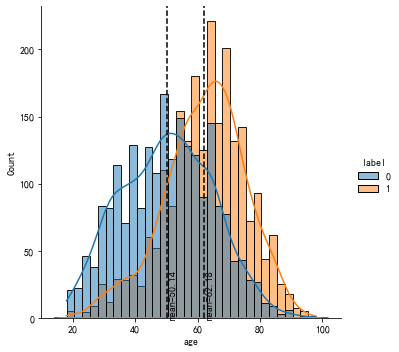

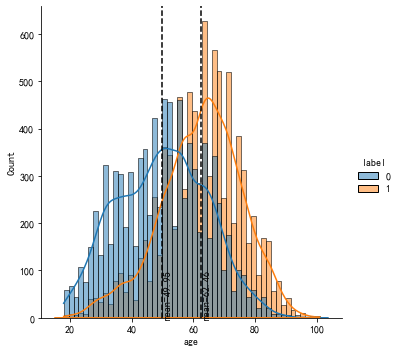

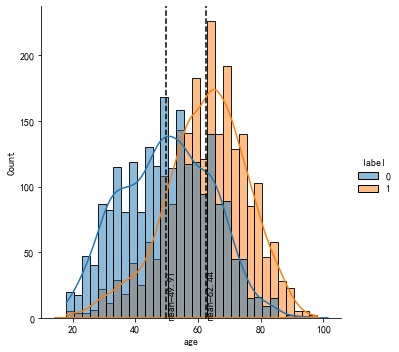

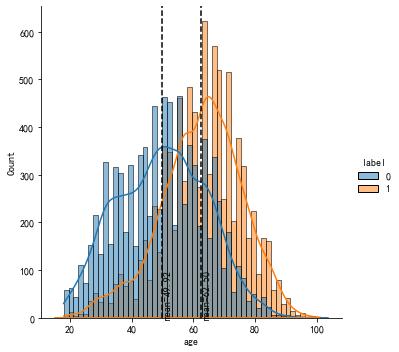

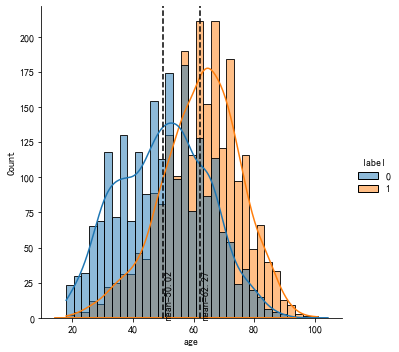

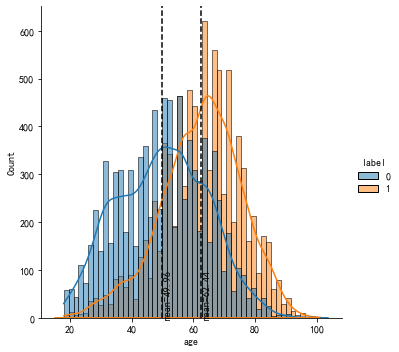

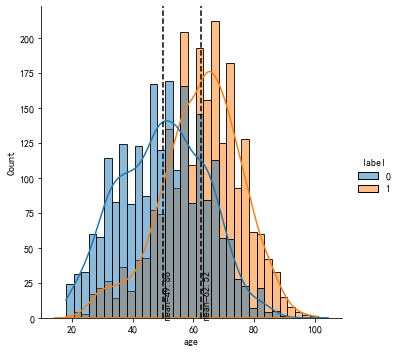

In [38]:

# Define the features used for stratification
features = [ 'age']

# Create the StratifiedKFold object with 5 folds
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=2020)

# Loop over the folds and split the data into train and test sets
for train_index, test_index in skf.split(df_merge,df_merge[[ 'age']]):
    X_train, X_test = df_merge.iloc[train_index], df_merge.iloc[test_index]
    display_age_label(X_train)
    display_age_label(X_test)


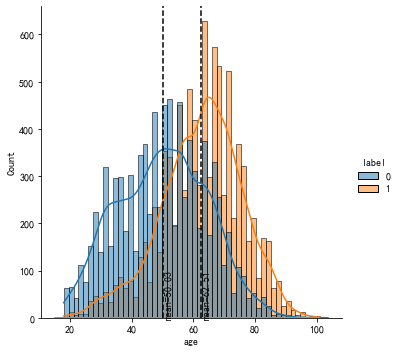

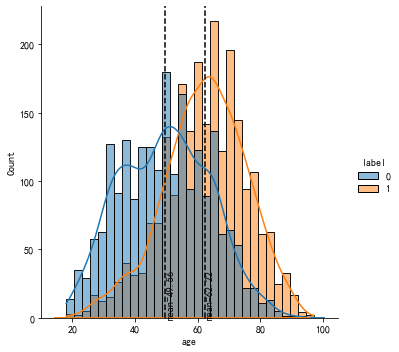

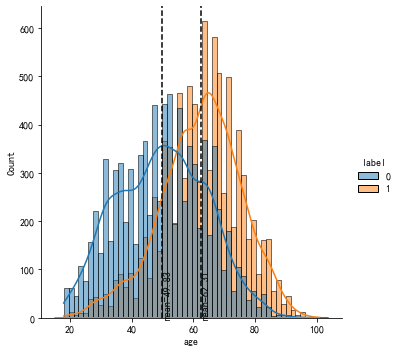

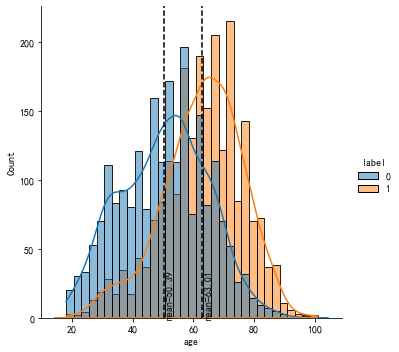

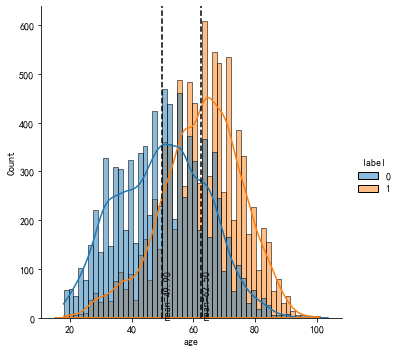

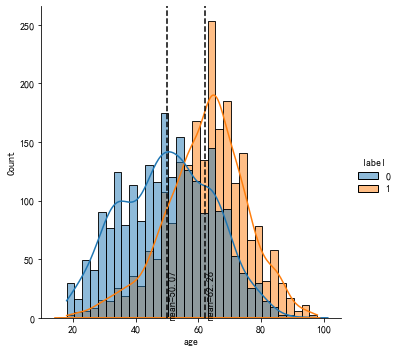

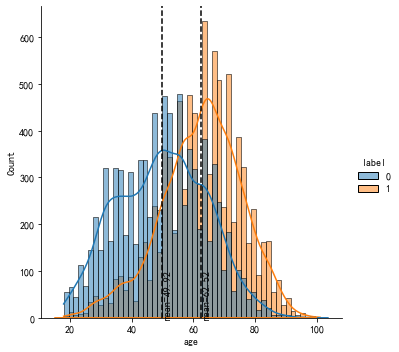

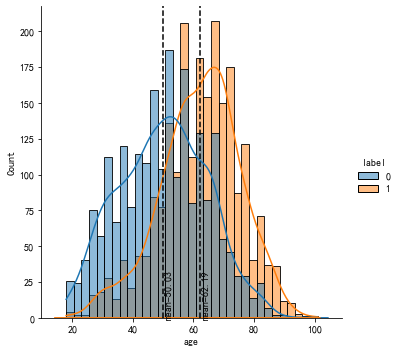

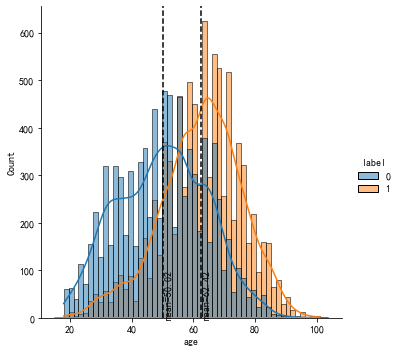

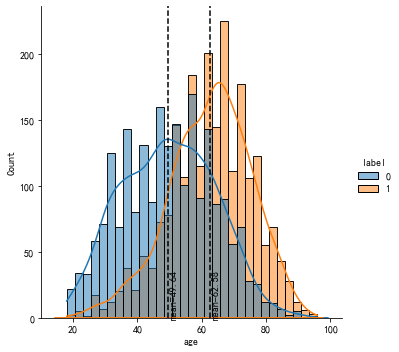

In [37]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True,random_state=42) # 初始化KFold对象，设置为5折，打乱数据，固定随机种子    
fold = 0 
for train_index , valida_index in kf.split(df_merge): # 调用split方法切分数据
    tarin_df,validate_df = df_merge.iloc[train_index], df_merge.iloc[valida_index] # 根据索引获取训练集和测试集的特征
    display_age_label(tarin_df)
    display_age_label(validate_df)

In [12]:
import seaborn as sns
def display_age_label(df_merge):
    # 绘制不同label的age分布
    sns.displot(data=df_merge, x='age', hue='label', kde=True)

    # 添加正态分布拟合曲线
    for label in df_merge['label'].unique():
        sns.kdeplot(data=df_merge[df_merge['label']==label], x='age', bw_adjust=0.4, label=label)

    # 标注平均值
    for label in df_merge['label'].unique():
        mean = df_merge[df_merge['label']==label]['age'].mean()
        plt.axvline(mean, color='black', linestyle='--')
        plt.text(mean+0.5, 0.02, f"mean={mean:.2f}", rotation=90)


In [7]:
def balanced_dataset(df):
    # Separate the dataframe into two based on the label
    label_0 = df[df['label'] == 0]
    label_1 = df[df['label'] == 1]
    
    # Get the number of samples in each label
    n_label_0 = len(label_0)
    n_label_1 = len(label_1)
    
    # Get the age distribution of each label
    age_dist_0 = label_0['age'].value_counts().sort_index()
    age_dist_1 = label_1['age'].value_counts().sort_index()
    
    # Create a new dataframe to store the balanced dataset
    new_df = pd.DataFrame(columns=df.columns)
    
    # Loop through each age in the age distribution of label 0
    for age_0, count_0 in age_dist_0.items():
        # Find the age in label 1 that is closest to age_0
        age_1 = age_dist_1.index[(age_dist_1 - count_0).abs().argmin()]
        
        # Get the samples with age_0 in label 0
        samples_0 = label_0[label_0['age'].between(age_0-5, age_0+5)]
        
        # Get the samples with age_1 in label 1
        samples_1 = label_1[label_1['age'].between(age_1-5, age_1+5)]
        
        # If there are no samples in label 1 with age_1, skip to the next age in label 0
        if len(samples_1) == 0:
            continue
        
        # Get the number of samples to take from each label
        n_samples = min(len(samples_0), len(samples_1))
        
        # Sample n_samples from each label without replacement
        samples_0 = samples_0.sample(n=n_samples, replace=False)
        samples_1 = samples_1.sample(n=n_samples, replace=False)
        
        # Concatenate the samples into the new dataframe
        new_df = pd.concat([new_df, samples_0, samples_1])
    
    return new_df


In [8]:
new_df = balanced_dataset(df_merge)

In [9]:
new_df.__len__()

550130

In [10]:
df_merge.__len__()

56036

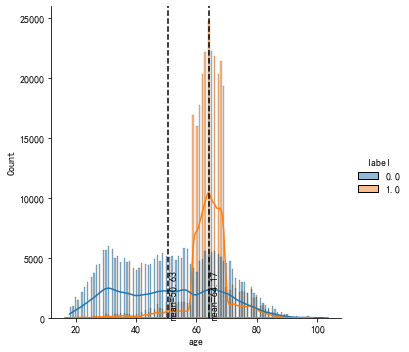

In [11]:
import seaborn as sns

# 绘制不同label的age分布
sns.displot(data=new_df, x='age', hue='label', kde=True)

# 添加正态分布拟合曲线
for label in new_df['label'].unique():
    sns.kdeplot(data=new_df[new_df['label']==label], x='age', bw_adjust=0.4, label=label)

# 标注平均值
for label in new_df['label'].unique():
    mean = new_df[new_df['label']==label]['age'].mean()
    plt.axvline(mean, color='black', linestyle='--')
    plt.text(mean+0.5, 0.02, f"mean={mean:.2f}", rotation=90)


In [16]:
ALL_data_buffer = df_merge.copy()
ALL_data_buffer = ALL_data_buffer.sample(frac=1).reset_index(drop=True) #打乱顺序
test_df = ALL_data_buffer[ALL_data_buffer['year']==22]
TV_df = ALL_data_buffer[ALL_data_buffer['year']!=22]

In [ ]:
# 按照指定的年龄区间和性别进行分组
bins = [18, 30, 40, 50, 60, 70, 80,110]
labels = ['18-30', '31-40', '41-50', '51-60', '61-70', '71-80','81-110']
ALL_data['agegroup'] = pd.cut(ALL_data['age'], bins=bins, labels=labels)
ALL_data.hist(column='agegroup',by = 'label',sharex=True)

In [7]:
print("{:^10} {:^10} {:^20}".format('  ','HTN','NHTN'))
print("{:^10} {:^10} {:^20}".format('nums',len(test_df[(test_df['label']==1)]),len(test_df[(test_df['label']==0)])))

print("{:^10} {:^10} {:^20}".format('  ','HTN','NHTN'))
print("{:^10} {:^10} {:^20}".format('nums',len(TV_df[(TV_df['label']==1)]),len(TV_df[(TV_df['label']==0)])))

              HTN             NHTN        
   nums       1102            906         
              HTN             NHTN        
   nums      13236            9631        


In [8]:
test_dataset = ECGHandle.ECG_Dataset(data_root,test_df,preprocess = True)

In [9]:
TV_dataset = ECGHandle.ECG_Dataset(data_root,TV_df,preprocess = True)

---

In [ ]:
data_root = '/workspace/data/Preprocess_HTN/datas_/'
ALL_data = pd.read_csv(data_root+'/All_data_handled_ID_range_age_IDimputate.csv',low_memory=False)
ALL_data = ECGHandle.change_label(ALL_data)
ALL_data = ECGHandle.filter_ID(ALL_data)
# ALL_data = ECGHandle.filter_departmentORlabel(ALL_data,'外科')
ALL_data = ECGHandle.filter_ages(ALL_data,18) 
ALL_data = ECGHandle.filter_QC(ALL_data)
ALL_data = ECGHandle.correct_label(ALL_data,reset_list = id_list)
ALL_data = ECGHandle.correct_age(ALL_data)
ALL_data = ECGHandle.filter_diagnose(ALL_data,'起搏')
ALL_data = ECGHandle.filter_diagnose(ALL_data,'房颤')
ALL_data = ECGHandle.filter_diagnose(ALL_data,'左束支传导阻滞')
ALL_data = ECGHandle.filter_diagnose(ALL_data,'左前分支阻滞')
ALL_data[ALL_data['label'] == 0]['住院号'].unique().__len__()
ALL_data = ALL_data.rename(columns={'住院号':'ID','年龄':'age','性别':'gender','姓名':'name'}) 
ALL_data_buffer = ALL_data.copy()

In [ ]:
seed_torch(2023)# keep the the set the same
ALL_data_buffer = ALL_data.copy()
ALL_data_buffer = ALL_data_buffer.sample(frac=1).reset_index(drop=True) #打乱顺序
####################################################################随机选取test
# test_df,tv_df = Pair_ID(ALL_data_buffer,0.2,Range_max=15,pair_num=1)
# ####################################################################随机选取test
test_df,tv_df = Pair_ID(ALL_data,0.2,Range_max=15,pair_num=1)
test_dataset = ECGHandle.ECG_Dataset(data_root,test_df,preprocess = True)

# test_df =all_dataset

In [ ]:
Models_path = '/workspace/data/Interpretable_HTN/model/20230320_011459/20230320_061146/BestF1_2.pt'
save_root = Models_path[:-3]+'/'    
layervalue_root = save_root+'/layervalue/'    
NET = [Net.MLBFNet_GUR_o(True,True,True,2,Dropout_rate=0.3), ] # type: ignore    
criterion = torch.nn.CrossEntropyLoss()    
testmodel = NET[0].to(DEVICE)    
testmodel.load_state_dict(torch.load(Models_path))    
test_dataloader = Data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)      
y_true,y_pred,y_out,test_loss,test_acc = eval_model(test_dataloader,criterion,testmodel,DEVICE) # 验证模型

In [ ]:
test_dataset.infos['out'] = np.array(y_out)[:,1]

In [ ]:
p_double_list = ['748939',
'764590',
'763667',
'579114',
'753320',
'795543',
'788055',
'757960',
'772546',
'786546',
'780224',
'813202',
'814775',
'544375',
'828347',
'840799',
'757558',
'803369',
'822443',
'801013',
'327715',
'812001',
'378927',
'839205',
'824053',
'809810',
'633009',
'826823',
'825537',
'794560',]

p_double_df = test_dataset.infos[[True if i in p_double_list else False for i in test_dataset.infos['ID']]]
p_double_df.to_csv('p_double_df.csv',encoding='utf-8-sig')

In [ ]:
def calculate_area(ECG:np.array,start_index:np.array,end_index:np.array): # type: ignore 
    p_area = 0
    for lead in range(12):
        for bet in range(len(start_index)):
            start = int(start_index[bet])
            end = int(end_index[bet])
            p_area = p_area + abs((ECG[lead,start:end] - ECG[lead,start:end].min()).sum())/(end-start)
    p_area = p_area/((len(start_index)))
    return p_area

In [ ]:
waves_location_file_root = '/workspace/data/Preprocess_HTN/datas_/Wave/'
lead_index = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
Amplitude_name_list = []
for i in range(12):
    Amplitude_name_list.append('P_Amplitude_'+lead_index[i])
    Amplitude_name_list.append('Q_Amplitude_'+lead_index[i])
    Amplitude_name_list.append('R_Amplitude_'+lead_index[i])
    Amplitude_name_list.append('S_Amplitude_'+lead_index[i])
    Amplitude_name_list.append('T_Amplitude_'+lead_index[i])
Amplitude_features_12leads =    pd.DataFrame(columns=Amplitude_name_list)
Timing_features = pd.DataFrame(columns=['P_wave_duration', 'QRS_duration', 'T_wave_duration','PQ_interval', 'PR_interval', 'QT_interval', 'QTc_interval', 'RR_interval','P_area'])
infos = pd.DataFrame(columns=test_dataset.infos.columns)

for index in range(test_dataset.__len__()):#test_dataset.__len__()
    try:
        info =test_dataset.infos.iloc[index]
        ECG,_ = test_dataset.__getitem__(index)
        ECGfile_name = info['ECGFilename']
        
        FPT = np.load(waves_location_file_root+'/FPT/'+ECGfile_name+'.npy')
        Timing_feature_sync = np.load(waves_location_file_root+'/Timing_feature_sync/'+ECGfile_name+'.npy')
        Amplitude_feature_12leads = np.load(waves_location_file_root+'/Amplitude_feature_12leads/'+ECGfile_name+'.npy')
        
        Amplitude_feature_12leads = pd.DataFrame((Amplitude_feature_12leads.transpose(1,0,2)[1:-1]).reshape(-1,60),columns=Amplitude_name_list) #lead,bet,5 -> bet,lead,5 ->bet,lead*5 
        FPT = pd.DataFrame(FPT[1:-1],columns=['P_start', 'P_peak', 'P_end','Q_start', 'Q_peak', 'R_peak', 'S_peak', 'S_end','res0','T_start', 'T_peak', 'T_end','res0'])
        Timing_feature_sync = pd.DataFrame(Timing_feature_sync[1:-1],columns=['P_wave_duration', 'QRS_duration', 'T_wave_duration','PQ_interval', 'PR_interval', 'QT_interval', 'QTc_interval', 'RR_interval'])
        
        Timing_feature = Timing_feature_sync 
        # Timing_feature = Timing_feature_sync.div(Timing_feature_sync['RR_interval'],axis=0) #(bet,13)把每个间隔除以每个RR间期
        # Timing_feature['RR_interval'] = Timing_feature_sync['RR_interval']#恢复RR间期
        Timing_feature = Timing_feature[1:-1].mean() #
        Timing_feature['P_area'] = calculate_area(np.array(ECG),np.array(FPT['P_start']),np.array(FPT['P_end']))
        
        
        Amplitude_feature = Amplitude_feature_12leads.mean()
        Amplitude_features_12leads = Amplitude_features_12leads.append(Amplitude_feature,True)
        Timing_features = Timing_features.append(Timing_feature,True )
        
        infos = infos.append(info)
    except:
        ECGfile_name = test_dataset.infos.iloc[index]['ECGFilename']
        print('Err :',ECGfile_name)
        continue

In [ ]:
Timing_features['ECGFilename'] = infos['ECGFilename'].values
Amplitude_features_12leads['ECGFilename'] = infos['ECGFilename'].values
select_info = ['name','ID','gender','age','检查时间','临床诊断', '诊断','ECGFilename', 'xmlPath', 'Q', 'label', 'out']
test_df_with_ECG_features = pd.merge(infos[select_info],pd.merge(Amplitude_features_12leads,Timing_features,on='ECGFilename',how='inner'),on='ECGFilename',how='inner')
test_df_with_ECG_features.to_csv('test_2023_infos_and_features.csv')

## 常规操作

In [ ]:
ALL_data = ALL_data.rename(columns={'住院号':'ID','年龄':'age','性别':'gender','姓名':'name'}) 
ALL_data_buffer = ALL_data.copy()
seed_torch(2023)
ALL_data_buffer = ALL_data_buffer.sample(frac=1).reset_index(drop=True) #打乱顺序
# all_dataset = ECGHandle.ECG_Dataset(data_root,ALL_data_buffer,preprocess = True)
####################################################################随机选取test
test_df,tv_df = Pair_ID(ALL_data,0.2,Range_max=15,pair_num=1)
test_dataset = ECGHandle.ECG_Dataset(data_root,test_df,preprocess = True)

In [ ]:
Models_path = '/workspace/data/Interpretable_HTN/model/20230322_030450/20230322_030450/BestF1_0.pt'
save_root = Models_path[:-3]+'/'    
layervalue_root = save_root+'/layervalue/'    
NET = [Net.MLBFNet_GUR_o(True,True,True,2,Dropout_rate=0.3), ] # type: ignore    
criterion = torch.nn.CrossEntropyLoss()    
testmodel = NET[0].to(DEVICE)    
testmodel.load_state_dict(torch.load(Models_path))    
test_dataloader = Data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)      
y_true,y_pred,y_out,test_loss,test_acc = eval_model(test_dataloader,criterion,testmodel,DEVICE) # 验证模型

In [ ]:
np.array(y_out).shape

In [ ]:
test_df_save = test_df.copy()
test_df_save['predict HTN possibility'] = np.array(y_out)[:,1]
print(test_df_save.head)

In [ ]:
test_df_save[test_df_save['label']==1].__len__()

In [ ]:
test_df_save.to_csv('./test.csv',encoding='utf_8_sig')

In [ ]:

ALL_data.columns

In [ ]:
duplicated_HTN_df = ALL_data[ALL_data.duplicated(subset=['ID'], keep=False) & (ALL_data['label']==1)& ( ~ ALL_data['检查时间'].isnull()) ]

In [ ]:
duplicated_HTN_df.__len__()

In [ ]:
duplicated_HTN_df['检查时间'] = pd.to_datetime(duplicated_HTN_df['检查时间'])

In [ ]:
duplicated_HTN_df['date_diff'] = duplicated_HTN_df.groupby('ID')['检查时间'].apply(lambda x:abs( x.diff()).dt.total_seconds())

In [ ]:
duplicated_HTN_ID_list_buffer = list(duplicated_HTN_df[duplicated_HTN_df['date_diff']>(31536000/2)]['ID'])
print(duplicated_HTN_ID_list_buffer.__len__())

In [ ]:
duplicated_HTN_df= ALL_data[ALL_data['ID'].isin(duplicated_HTN_ID_list_buffer)].copy()
duplicated_HTN_dataset = ECGHandle.ECG_Dataset(data_root,duplicated_HTN_df,preprocess = True)

In [ ]:
Models_path = '/workspace/data/Interpretable_HTN/model/20230322_030450/20230322_030450/BestF1_0.pt'
save_root = Models_path[:-3]+'/'    
layervalue_root = save_root+'/layervalue/'    
NET = [Net.MLBFNet_GUR_o(True,True,True,2,Dropout_rate=0.3), ] # type: ignore    
criterion = torch.nn.CrossEntropyLoss()    
testmodel = NET[0].to(DEVICE)    
testmodel.load_state_dict(torch.load(Models_path))    
duplicated_HTN_dataloader = Data.DataLoader(dataset=duplicated_HTN_dataset, batch_size=1, shuffle=False)      
y_true,y_pred,y_out,test_loss,test_acc = eval_model(duplicated_HTN_dataloader,criterion,testmodel,DEVICE) # 验证模型

In [ ]:
duplicated_HTN_df['predict HTN possibility'] = np.array(y_out)[:,1]

In [ ]:
duplicated_HTN_df[duplicated_HTN_df['predict HTN possibility']<0.5]['ID'].unique().tolist()

In [ ]:
duplicated_HTN_df.to_csv('./duplicated_HTN_间隔半年以上.csv',encoding='utf_8_sig')

In [ ]:
jpg_path = './jpg/duplicated_HTN/'
for index in range(duplicated_HTN_dataset.__len__()):#test_dataset.__len__()
    info =duplicated_HTN_dataset.infos.iloc[index]
    file_name = info['ID']+'_'+info['ECGFilename']
    ID = info['ID']
    date = info['检查时间']
    age = info['age']
    label = info['label']
    ECG,labels = duplicated_HTN_dataset.__getitem__(index)
    ECG = ECG*5000 #恢复
    ecg_plot.plot(ECG*4.88/1000, sample_rate = 500, title = 'ID:'+str(ID)+' '+ 'label: '+ str(label) +' '+'Date: '+str(date)+' '+'age: '+str(age)  ,row_height= 10,show_grid=True,show_separate_line=True)
    ecg_plot.save_as_jpg(file_name,jpg_path)

## 测试集上分类错误的NHTN

In [ ]:
ERR_NHTN_df = test_df_save[ (test_df_save['label']==0) & (test_df_save['predict HTN possibility']>=0.5) ]
print(ERR_NHTN_df)

In [ ]:
ERR_NHTN_df.to_csv('./ERR_NHTN.csv',encoding='utf_8_sig')

## std & mean check

In [ ]:
FOLDS = 5
seed_torch(2023)
tv_df = tv_df.sample(frac=1).reset_index(drop=True) #打乱顺序

In [ ]:
for fold in range(FOLDS):
    print("Fold "+str(fold)+" of "+str(FOLDS) + ' :')
    tv_df_buffer = tv_df.copy()
    HTN_tv_df = tv_df[(tv_df['label']==1) ].copy()
    NHTN_tv_df = tv_df[(tv_df['label']==0) ].copy()
    HTN_ID_tv_list = HTN_tv_df['ID'].unique().tolist() #tvset中所有的HTN的ID号
    HTN_tv_size = HTN_tv_df['ID'].unique().__len__()
    HTN_validate_size = int(HTN_tv_size//FOLDS)
    validate_start_index = HTN_validate_size*fold #star index for validate
    validate_df,tarin_df = Pair_ID(tv_df_buffer,0.2,star_index=validate_start_index,Range_max=15,pair_num=1)
    validate_dataset = ECGHandle.ECG_Dataset(data_root,validate_df,preprocess = True)
    
    train_pair_df,_ = Pair_ID(tarin_df,1,star_index=0,Range_max=15,pair_num=1,shuffle=True)
    train_dataset = ECGHandle.ECG_Dataset(data_root,train_pair_df ,preprocess = True)
    for i in range(12):
        print('lead:' ,i)
        print('test:{}',test_dataset.datas[:,i,:].std(),test_dataset.datas[:,i,:].mean())
        print('train:{}',train_dataset.datas[:,i,:].std(),train_dataset.datas[:,i,:].mean())
        print('validat:{}',validate_dataset.datas[:,i,:].std(),validate_dataset.datas[:,i,:].mean())

In [ ]:
test_df[test_df['label'] == 0]['ID'].__len__()

In [ ]:
tv_df[tv_df['label'] == 0]['ID'].__len__()

## 查看训练集、测试集、验证集的年龄、性别分布是否有差别

In [ ]:
ALL_data.columns

In [ ]:
ALL_data.hist(column='age', by='gender')

In [ ]:
test_df.hist(column='age', by='gender')

In [ ]:
seed_torch(2023)
test_df,tv_df = Pair_ID(ALL_data,0.2,Range_max=15,pair_num=1)
FOLDS = 5
seed_torch(2020)
tv_df = tv_df.sample(frac=1).reset_index(drop=True) #打乱顺序
for fold in range(FOLDS):
    print("Fold "+str(fold)+" of "+str(FOLDS) + ' :')
    tv_df_buffer = tv_df.copy()
    HTN_tv_df = tv_df[(tv_df['label']==1) ].copy()
    NHTN_tv_df = tv_df[(tv_df['label']==0) ].copy()
    HTN_ID_tv_list = HTN_tv_df['ID'].unique().tolist() #tvset中所有的HTN的ID号
    HTN_tv_size = HTN_tv_df['ID'].unique().__len__()
    HTN_validate_size = int(HTN_tv_size//FOLDS)
    validate_start_index = HTN_validate_size*fold #star index for validate
    validate_df,tarin_df = Pair_ID(tv_df_buffer,0.2,star_index=validate_start_index,Range_max=15,pair_num=1)
    
    train_pair_df,_ = Pair_ID(tarin_df,1,star_index=0,Range_max=15,pair_num=1,shuffle=True)
    validate_df.hist(column='age', by='gender')
    tarin_df.hist(column='age', by='gender')

#### 按照[18, 30, 40, 50, 60, 70, 110]年龄分组

In [ ]:
# 按照指定的区间进行分组
bins = [18, 40, 60, 80, 110]
labels = ['18-40', '41-60', '61-80', '81-110']
ALL_data['agegroup'] = pd.cut(ALL_data['age'], bins=bins, labels=labels)
ALL_data.hist('agegroup',by = 'label',sharex=True)

In [ ]:
# 按照指定的区间进行分组
bins = [18, 30, 40, 50, 60, 70, 80,110]
labels = ['18-30', '31-40', '41-50', '51-60', '61-70', '71-80','81-110']
ALL_data['agegroup'] = pd.cut(ALL_data['age'], bins=bins, labels=labels)
ALL_data.hist(column='agegroup',by = 'label',sharex=True)

In [ ]:
HTN_df = ALL_data[(ALL_data['label']==1) ].drop_duplicates(subset=['ID'],keep = 'first').copy()

In [ ]:
from sklearn.model_selection import train_test_split
# 按照agerange和gender进行分层抽样

NHTN_df = ALL_data[(ALL_data['label']==0) ].drop_duplicates(subset=['ID'],keep = 'first').copy()
HTN_df = ALL_data[(ALL_data['label']==1) ].drop_duplicates(subset=['ID'],keep = 'first').copy()
TV_HTN_df, test_HTN_df = train_test_split(HTN_df, test_size=0.2, stratify=HTN_df[['agegroup', 'gender']])
test_ID_list = pair_HTN(test_HTN_df.drop_duplicates(['ID'],keep='first'),NHTN_df.drop_duplicates(['ID'],keep='first'),
                            Range_max=2,
                            pair_num=1,
                            shuffle=True)['ID'].tolist()#按照年龄和性别对每个ID号去配对 (先去除重复ID)
pair_index = ALL_data[[True if i in test_ID_list else False for i in ALL_data['ID']]].index
test_df = ALL_data.loc[pair_index].copy()
left_index = ALL_data[[False if i in test_ID_list else True for i in ALL_data['ID']]].index #不在test_ID_list的ID 即为tv的
TV_df = ALL_data.loc[left_index].copy()



TV_NHTN_df = TV_df[(TV_df['label']==0) ].drop_duplicates(subset=['ID'],keep = 'first').copy()
TV_HTN_df = TV_df[(TV_df['label']==1) ].drop_duplicates(subset=['ID'],keep = 'first').copy()
fold_len= float((TV_HTN_df.__len__())//5) #每一fold的HTN的长度
TV_HTN_buffer = TV_HTN_df.copy()

validat_HTN_df_subsets = []
for i in range(4):
    TV_HTN_buffer, subset = train_test_split(TV_HTN_buffer, test_size=fold_len/(TV_HTN_buffer.__len__()), stratify=TV_HTN_buffer[['agegroup', 'gender']])
    print(subset.__len__())
    validat_HTN_df_subsets.append(subset)
print(TV_HTN_buffer.__len__())
validat_HTN_df_subsets.append(TV_HTN_buffer)

validat_ID_list_subsets = []
for i in range(validat_HTN_df_subsets.__len__()):
    i_ID_list = pair_HTN(validat_HTN_df_subsets[i].drop_duplicates(['ID'],keep='first'),
                         TV_NHTN_df.drop_duplicates(['ID'],keep='first'),
                            Range_max=2,
                            pair_num=1,
                            shuffle=True)['ID'].tolist()#按照年龄和性别对每个ID号去配对 (先去除重复ID)
    validat_ID_list_subsets.append(i_ID_list)


In [ ]:
for fold in range(5):
    print(" "*10+ "Fold "+str(fold)+" of "+str(5) + ' :')

    pair_index = TV_df[[True if i in validat_ID_list_subsets[fold] else False for i in TV_df['ID']]].index
    validate_df = TV_df.loc[pair_index].copy()
    left_index = TV_df[[False if i in validat_ID_list_subsets[fold] else True for i in TV_df['ID']]].index #不在test_ID_list的ID 即为tv的
    train_df = TV_df.loc[left_index].copy()
    train_pair_df,_ = Pair_ID(train_df,1,star_index=0,Range_max=5,pair_num=1,shuffle=True)

    validate_df.hist('age',by = 'label',sharex=True)
    train_pair_df.hist('age',by = 'label',sharex=True)

In [ ]:
test_df.hist('age',by = 'label',sharex=True)

## plot

In [ ]:
jpg_path = './jpg/'
for index in range(test_dataset.__len__()):#test_dataset.__len__()
    info =test_dataset.infos.iloc[index]
    file_name = info['ECGFilename']
    ID = info['ID']
    date = info['检查时间']
    age = info['age']
    label = info['label']
    ECG,labels = test_dataset.__getitem__(index)
    ECG = ECG*5000 #恢复
    ecg_plot.plot(ECG*4.88/1000, sample_rate = 500, title = 'ID:'+str(ID)+' '+ 'label: '+ str(label) +' '+'Date: '+str(date)+' '+'age: '+str(age)  ,row_height= 10,show_grid=True,show_separate_line=True)
    ecg_plot.save_as_jpg(file_name,jpg_path)